## Calculate the TSN intrinsic value

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
# fixed parameters
path_data = '../input/TSN_Q_exp.csv'
report = 'Q'
# end date years ago
finished_years_ago = 0
# forecast period
forecast_period = 20
# WACC input
share_price = 54
us_bond_10_yr = 0.0436
# country specifc - USA data from https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ctryprem.html - 5.5% 10+ yrs average
equity_risk_premium = 0.055
beta = 0.78
# country industry growth rate - US GDP growth avg from 1948 yo 2023 - 3.12%
industry_growth_rate = 0.0312

In [3]:
#load data
data = pd.read_csv(path_data, sep=';', parse_dates=[2])
print('Data are available from:', data.date.iloc[0])
# start date 7 year earlier than end date
start_date = pd.Timestamp(datetime.date.today()) - (pd.Timedelta(days=(10 * 365) + (finished_years_ago * 365)))
end_date = pd.Timestamp(datetime.date.today()) - (pd.Timedelta(days=finished_years_ago * 365))
# create DataFrame
data_filt = data.loc[(data['report'] == report) & (data['date'] > start_date) & (data['date'] < end_date), :]
data_filt.reset_index(drop=True, inplace=True)
print('Filtered data start at:', data_filt.date.iloc[0])
print('Filtered data finish at:', data_filt.date.iloc[-1])

Data are available from: 2002-01-01 00:00:00
Filtered data start at: 2013-10-01 00:00:00
Filtered data finish at: 2023-07-01 00:00:00


In [4]:
data_filt.head()

,ticker,report,date,rev,cost_sale,r_d,sale_gen_adm,inpairm,other_charg,op_income,...,short_debt,acc_pay,other_curr_liab,tot_curr_liab,tot_long_debt,other_liab,tot_equity,tot_liab,depr_amort,stock_b_comp
0,TSN,Q,2013-10-01,8822,8091,0,249,0,0,482,...,513,1359,1138,3010,1895.0,560,6233,5944,132,9.00
1,TSN,Q,2014-01-01,8761,8076,0,273,0,0,412,...,52,1477,1077,2606,1890.0,582,6316,5528,127,12.75
2,TSN,Q,2014-04-01,9032,8381,0,290,0,0,361,...,52,1429,1024,2505,1888.0,585,6464,5422,127,12.75
3,TSN,Q,2014-07-01,9682,9045,0,286,0,0,351,...,41,1496,1075,2612,1784.0,545,6710,5345,128,12.75
4,TSN,Q,2014-10-01,10105,9393,0,406,0,0,306,...,643,1806,1207,3797,7535.0,1270,8904,15052,148,12.75


### Calculate EBITDA, EBIT, NOPAT, CAPEX etc on hisorical data

In [5]:
def calculate_missing_columns(df):
    df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm'] - df['r_d'] - df['other_charg']
    df['ebit'] = df['ebitda'] - df['depr_amort']
    df['nopat'] = df['ebit'] - df['inc_tax_exp']
    df['other_curr_ass_lesscash'] = df['acc_rec'] + df['invent'] + df['other_curr_ass']
    df['tot_curr_liab_lessdebt'] = df['tot_curr_liab'] - df['short_debt']
    df['nwc'] = df['other_curr_ass_lesscash'] - df['tot_curr_liab_lessdebt']
    # capex calculation
    capex = []
    for index in range(len(df)):
        if index > 0:
            ppe_change = df['ppe_net'].iloc[index] - df['ppe_net'].iloc[index-1]
            depr_amort = df['depr_amort'].iloc[index]
            capex.append(ppe_change + depr_amort)
        else:
            capex.append(np.nan)
    df.loc[:, 'capex'] = capex

    return df

In [6]:
data_filt = calculate_missing_columns(data_filt)
data_filt.head()

/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_2615/3706664529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm'] - df['r_d'] - df['other_charg']
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_2615/3706664529.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ebit'] = df['ebitda'] - df['depr_amort']
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_2615/3706664529.py:4: SettingWithCopyWarning: 
A value is 

,ticker,report,date,rev,cost_sale,r_d,sale_gen_adm,inpairm,other_charg,op_income,...,tot_liab,depr_amort,stock_b_comp,ebitda,ebit,nopat,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,capex
0,TSN,Q,2013-10-01,8822,8091,0,249,0,0,482,...,5944,132,9.00,482,350,226,4459,2497,1962,NaN
1,TSN,Q,2014-01-01,8761,8076,0,273,0,0,412,...,5528,127,12.75,412,285,154,4405,2554,1851,146.0
2,TSN,Q,2014-04-01,9032,8381,0,290,0,0,361,...,5422,127,12.75,361,234,103,4746,2453,2293,160.0
3,TSN,Q,2014-07-01,9682,9045,0,286,0,0,351,...,5345,128,12.75,351,223,171,4926,2571,2355,-36.0
4,TSN,Q,2014-10-01,10105,9393,0,406,0,0,306,...,15052,148,12.75,306,158,76,5337,3154,2183,1337.0


### 2.1. Forecast Revenue

Before the ARIMA / SARIMA modling need to know p, d, q values (model parameters):
- p: Trend autoregression order.
- q: Trend moving average order.
- d: Trend difference order.

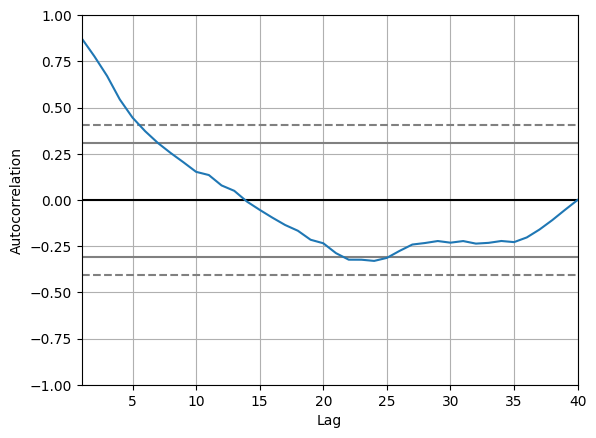

In [7]:
# Creating Autocorrelation plot - ACF
x = pd.plotting.autocorrelation_plot(data_filt['rev'])
x.plot()
plt.show()

The monotony of ACF is changed first time there is the p value. 

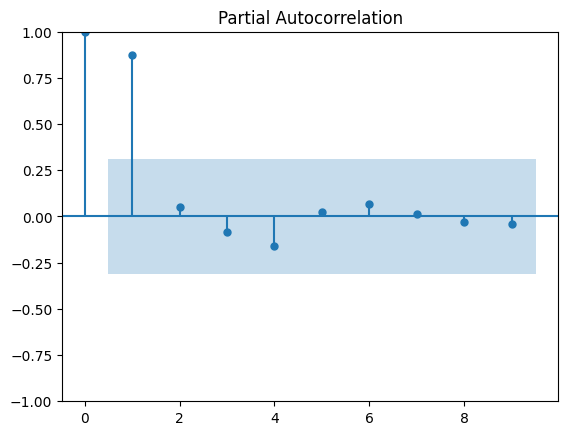

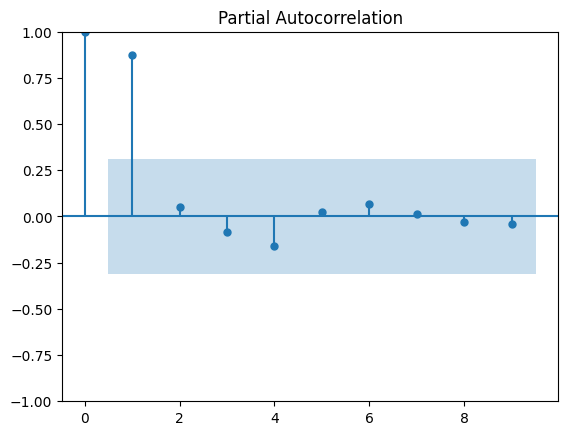

In [8]:
# Creating Partial Autocorrelation plot --> PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_filt['rev'], lags = int(forecast_period / 2 - 1))

Number of points, which are far away from the boundary is the q value.

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how a decide the q value. Hence the value of q is 2.

The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

I will find ARIMA hyperparameters (p, d, q) with gridsearch step-by-step

In [9]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    print(error)
    return error

In [10]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [11]:
# evaluate an ARIMA model for a given order (p,d,q) ---> You can tip p and estimate d, q based on previous plots
series = data_filt['rev']
# evaluate parameters
p_values = [2, 4, 6, 8, 10]
d_values = [1]
q_values = [1, 2, 3 ,4]
warnings.filterwarnings("ignore")
best_config = evaluate_models(series.values, p_values, d_values, q_values)

429406.16273671243
ARIMA(2, 1, 1) MSE=429406.163
526284.2323495792
ARIMA(2, 1, 2) MSE=526284.232
514753.4943537655
ARIMA(2, 1, 3) MSE=514753.494
592134.7952600418
ARIMA(2, 1, 4) MSE=592134.795
451017.95407338114
ARIMA(4, 1, 1) MSE=451017.954
478438.79609207617
ARIMA(4, 1, 2) MSE=478438.796
565842.28830117
ARIMA(4, 1, 3) MSE=565842.288
602655.8443921186
ARIMA(4, 1, 4) MSE=602655.844
495280.20626672043
ARIMA(6, 1, 1) MSE=495280.206
404430.0901578871
ARIMA(6, 1, 2) MSE=404430.090
489210.30486023874
ARIMA(6, 1, 3) MSE=489210.305
466513.2702513061
ARIMA(6, 1, 4) MSE=466513.270
475706.48106265237
ARIMA(8, 1, 1) MSE=475706.481
413740.6260953009
ARIMA(8, 1, 2) MSE=413740.626
502665.79595122667
ARIMA(8, 1, 3) MSE=502665.796
443995.1174347479
ARIMA(8, 1, 4) MSE=443995.117
517111.5900406603
ARIMA(10, 1, 1) MSE=517111.590
544061.1091974302
ARIMA(10, 1, 2) MSE=544061.109
552301.9258249507
ARIMA(10, 1, 3) MSE=552301.926
507128.85836431
ARIMA(10, 1, 4) MSE=507128.858
Best ARIMA(6, 1, 2) MSE=404430.09

The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model.

The parameter "s" is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect. Here is hardcoded, works well with 12.

In [12]:
# float datatype is needed to SARIMAX model
data_filt['rev'] = data_filt['rev'].astype(float)

In [13]:
# use the model parameters of SARIMA
p, d, q = best_config
model=sm.tsa.statespace.SARIMAX(data_filt['rev'].values,
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33418D+00    |proj g|=  1.81780D-01


 This problem is unconstrained.



At iterate    5    f=  5.25924D+00    |proj g|=  4.91583D-03

At iterate   10    f=  5.25911D+00    |proj g|=  1.79976D-03

At iterate   15    f=  5.25908D+00    |proj g|=  3.21108D-04

At iterate   20    f=  5.25906D+00    |proj g|=  2.17449D-03

At iterate   25    f=  5.25904D+00    |proj g|=  1.05256D-03

At iterate   30    f=  5.25885D+00    |proj g|=  3.45821D-03

At iterate   35    f=  5.25710D+00    |proj g|=  3.55137D-02

At iterate   40    f=  5.24732D+00    |proj g|=  6.47508D-02

At iterate   45    f=  5.23591D+00    |proj g|=  4.13703D-02

At iterate   50    f=  5.22139D+00    |proj g|=  4.10420D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [14]:
# use SARIMAX model
prediction_revenue = model.predict(len(data_filt), len(data_filt) + forecast_period)
# df from results
prediction = pd.DataFrame(
    prediction_revenue,
    index=[i+1 for i in range(len(prediction_revenue))],
    columns=['rev']
)

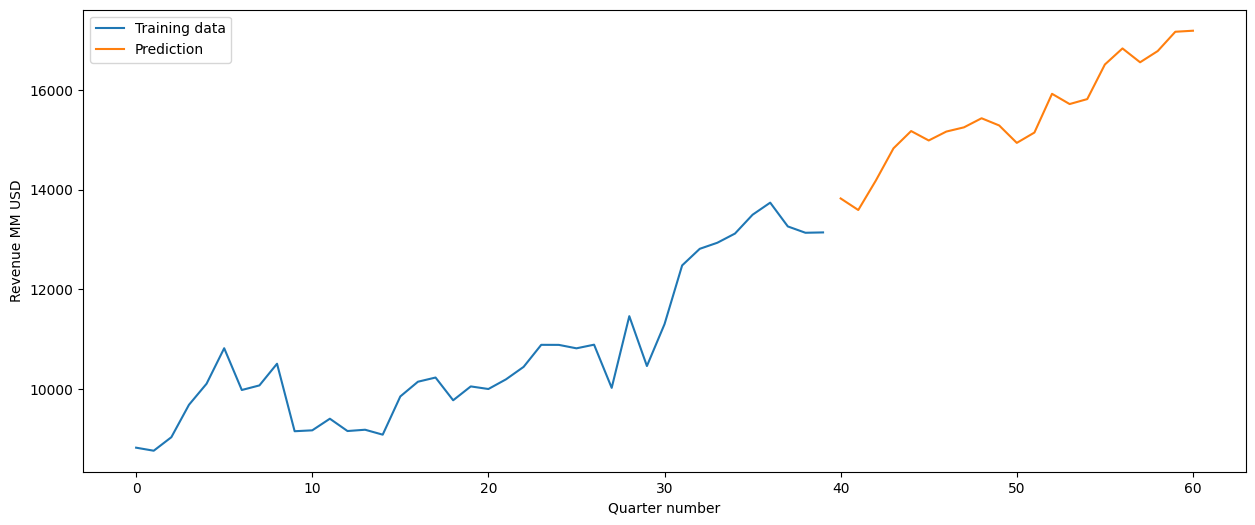

In [15]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(data_filt['rev'].index, data_filt['rev'].values, label='Training data')
ax1.plot(prediction.index+len(data_filt)-1, prediction['rev'], label='Prediction')

ax1.set_xlabel('Quarter number')
ax1.set_ylabel('Revenue MM USD')

plt.legend()
plt.show()

### 2.2. Calculate ratios

After the revenue prediction I calculate the expenses and use those to predict future CoS and EBITDA.

In [16]:
# create a function to calculate ratios
def calculate_margins(df):
    is_incomes = ['cost_sale', 'sale_gen_adm', 'r_d', 'other_charg']
    calc_margins = dict()
    # plot and calculate ratios
    for income in is_incomes:
        if income != 'inc_tax_exp':
            div = 'rev'
        else:
            div = 'inc_b_tax'

        fig, ax1 = plt.subplots(figsize=(15, 6))

        ax1.plot(df['date'], df[income]/df[div], label=income.replace('_', ' ').upper())
        ax1.axhline(y=(df[income]/df[div]).mean(), color='r', label='Average value')
        
        ax1.set_xlabel('Date')
        ax1.set_ylabel(income.replace('_', ' ').upper())
        
        plt.legend()
        plt.show()

        calc_margins[income+'_margin'] = (df[income]/df[div]).mean()

        print(str(income)+' is divided by the revenue.')
        print('Average value: '+str((df[income]/df[div]).mean()))

    return calc_margins

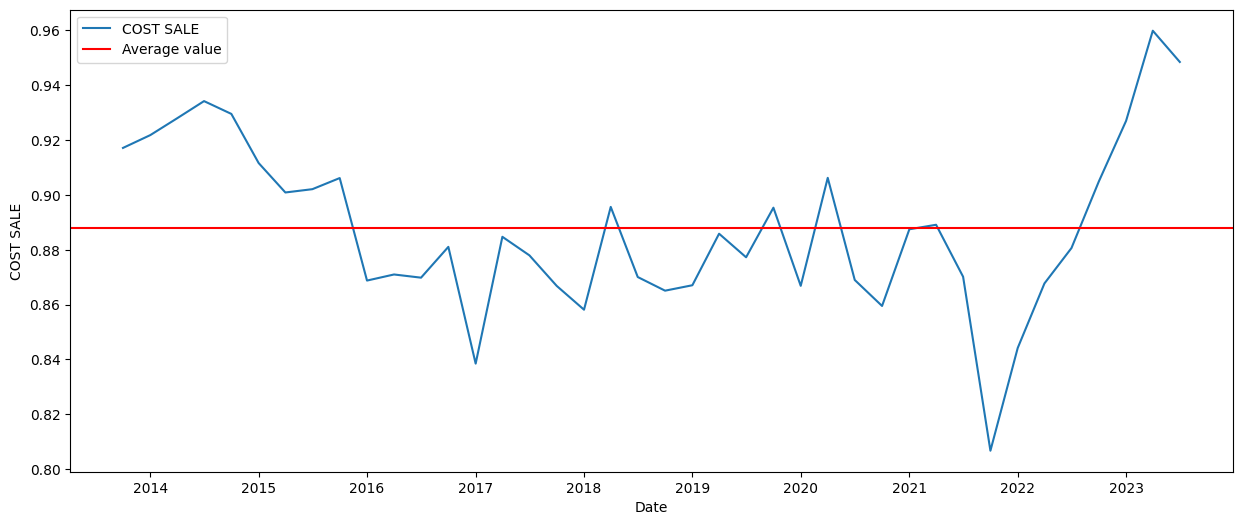

cost_sale is divided by the revenue.
Average value: 0.8878084353720022


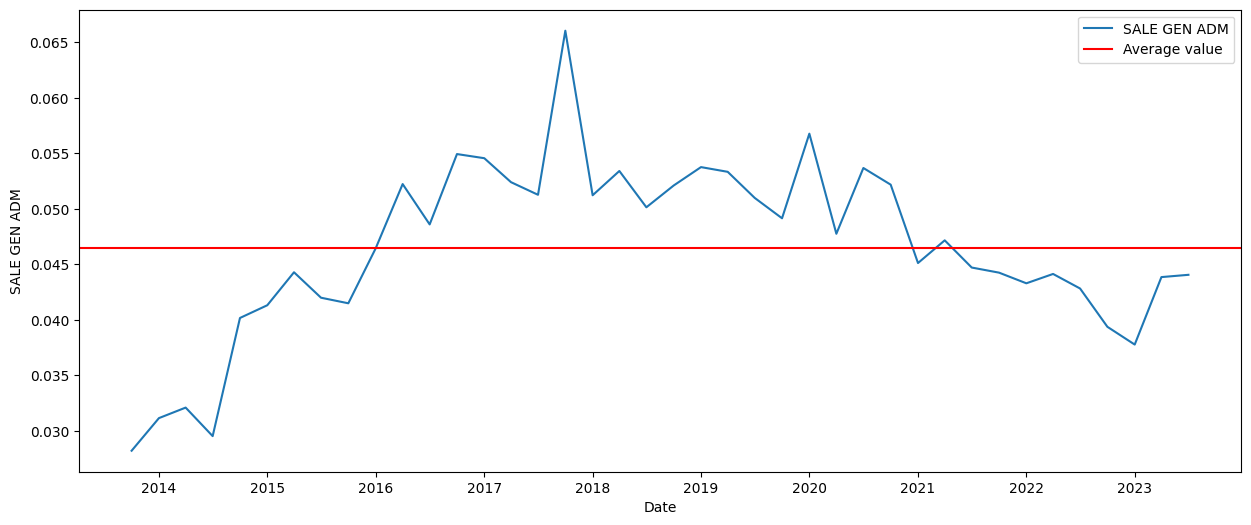

sale_gen_adm is divided by the revenue.
Average value: 0.046449459511770035


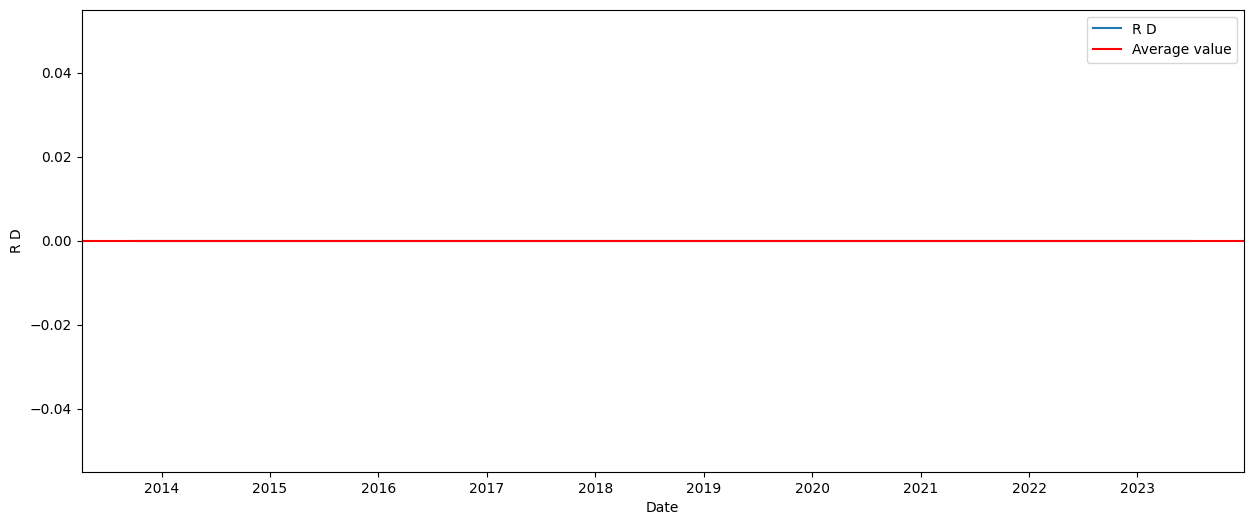

r_d is divided by the revenue.
Average value: 0.0


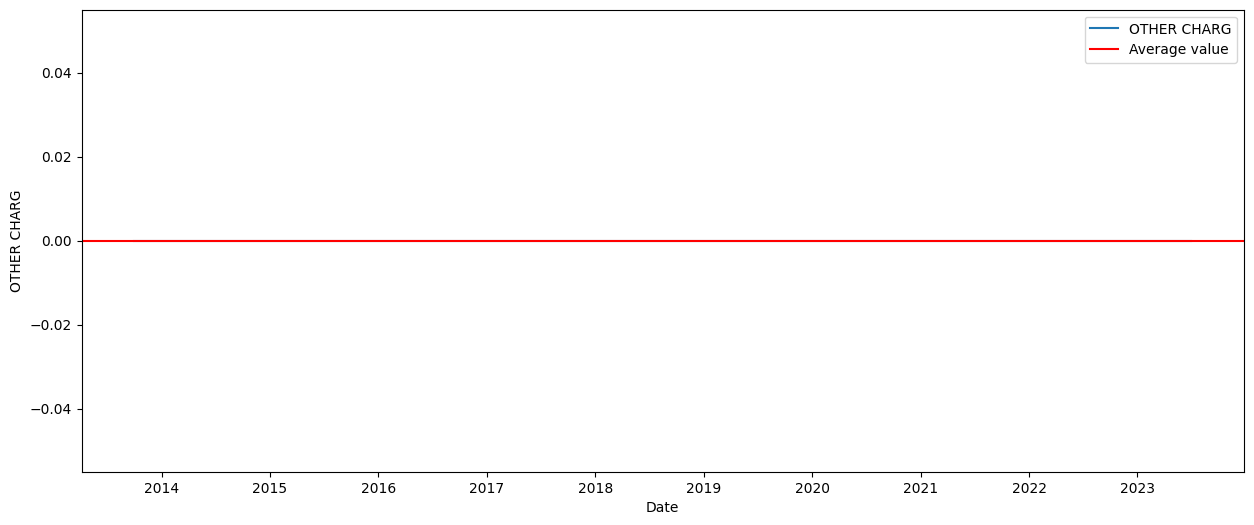

other_charg is divided by the revenue.
Average value: 0.0


In [17]:
base_case = calculate_margins(data_filt)

In [18]:
#prediction['ebit'] = prediction['ebitda'] - prediction['depr_amort']
for column in ['cost_sale', 'sale_gen_adm', 'r_d', 'other_charg']:
    prediction[column] = prediction['rev'] * base_case[column+'_margin']

prediction.tail()

,rev,cost_sale,sale_gen_adm,r_d,other_charg
17,16830.583186,14942.333725,781.771492,0.0,0.0
18,16552.723821,14695.647837,768.865075,0.0,0.0
19,16777.965461,14895.619265,779.327427,0.0,0.0
20,17165.129605,15239.346857,797.310993,0.0,0.0
21,17185.794338,15257.693182,798.270858,0.0,0.0


## 2.3. Calculate Fixed Assets

It's time to calculate D&A costs.

I will predict the PPE, D&A and CapEx values together.

In [19]:
def fixed_asset_ratios(df):
    # fixed asset sliced dataframe
    fixed_asset = df.loc[:, ['ppe_net', 'depr_amort']]
    # calculate PPE start & CAPEX
    fixed_asset['ppe_net_start'] = [fixed_asset['ppe_net'].values[i-1] if i > 0 else np.nan for i in range(len(fixed_asset['ppe_net'].values))]
    fixed_asset['capex'] = fixed_asset['ppe_net'] - fixed_asset['ppe_net_start'] + fixed_asset['depr_amort']
    
    #calculate ratio
    fixed_asset_ratios = dict()
    # D&A ratio
    for column in ['depr_amort', 'capex']:
        ratio = fixed_asset[column]/fixed_asset['ppe_net_start']
        ratio.hist()
        plt.show()
        fixed_asset_ratios[column+'_ratio'] = ratio.mean()
        print('Average', column, 'value is', fixed_asset_ratios[column+'_ratio'])
    return fixed_asset_ratios

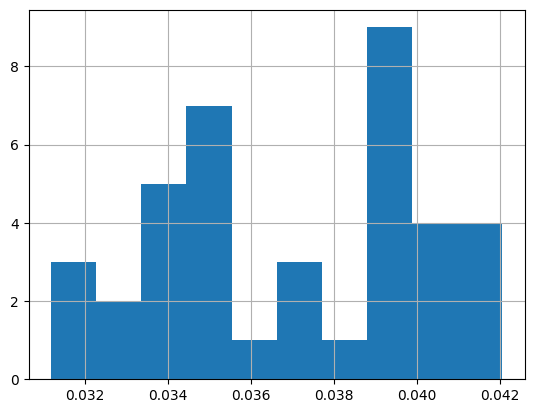

Average depr_amort value is 0.03698987142959152


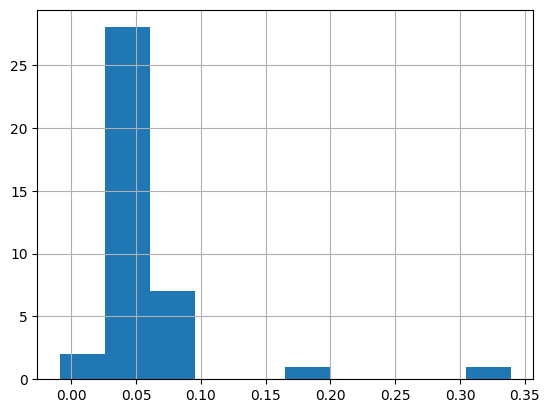

Average capex value is 0.06054521962291213


In [20]:
fxd_ass_ratios = fixed_asset_ratios(data_filt)

In [21]:
def predict_fixed_assets(raw_df, prediction_df, fxd_ass_ratios):
    # get the last measured PPE as start in case of prediction
    ppe_start_pred = [raw_df['ppe_net'].iloc[-1]]
    depr_amort_pred = []
    capex_pred = []
    ppe_net = []
    # calculate prediction
    for index in range(len(prediction_df)):
        depr_amort_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['depr_amort_ratio'])
        capex_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['capex_ratio'])
        ppe_net.append(ppe_start_pred[-1] - depr_amort_pred[-1] + capex_pred[-1])
        # add the last PPE as starting to the PPE start
        ppe_start_pred.append(ppe_net[-1])
    
    prediction_df['depr_amort'] = depr_amort_pred
    prediction_df['capex'] = capex_pred
    prediction_df['ppe_net'] = ppe_net

    return prediction_df

In [22]:
prediction = predict_fixed_assets(data_filt, prediction, fxd_ass_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net
1,13821.261465,12270.632516,641.990125,0.0,0.0,355.546644,581.960651,9838.414007
2,13589.515884,12064.886835,631.225668,0.0,0.0,363.921669,595.668937,10070.161274
3,14182.205809,12591.081950,658.755795,0.0,0.0,372.493971,609.700126,10307.367430
4,14827.036974,13163.568497,688.707854,0.0,0.0,381.268196,624.061825,10550.161058
5,15173.068943,13470.778598,704.780852,0.0,0.0,390.249101,638.761818,10798.673776


## 2.4. Calculate EBITDA, EBIT, NOPAT

In [23]:
def calc_eff_tax_rate(df):
    if df['date'].iloc[-1] > pd.Timestamp('2017-01-01'):
        eff_tax_rate = 0.21
    else:
        eff_tax_rate = (data_filt['inc_tax_exp']/data_filt['ebit']).mean()
        # plot
        (data_filt['inc_tax_exp']/data_filt['ebit']).hist(range=[0, 1])
        plt.show()

    print('Effective tax rate is', eff_tax_rate)
    return eff_tax_rate

eff_tax_rate = calc_eff_tax_rate(data_filt)

Effective tax rate is 0.21


In [24]:
def calculate_ebitda_ebit_nopat(prediction_df, eff_tax_rate):
    # if R&D or Other expenses missing itt will add nan, must to replace nan with 0
    prediction_df['r_d'] = prediction_df['r_d'].fillna(0.0)
    prediction_df['other_charg'] = prediction_df['other_charg'].fillna(0.0)
    prediction_df['ebitda'] = prediction_df['rev'] - prediction_df['cost_sale'] - prediction_df['sale_gen_adm'] - prediction_df['r_d'] - prediction_df['other_charg']
    prediction_df['ebit'] = prediction_df['ebitda'] - prediction_df['depr_amort']
    prediction_df['nopat'] = prediction_df['ebit'] - (prediction_df['ebit'] * eff_tax_rate)
    return prediction_df

In [25]:
prediction = calculate_ebitda_ebit_nopat(prediction, eff_tax_rate)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net,ebitda,ebit,nopat
1,13821.261465,12270.632516,641.990125,0.0,0.0,355.546644,581.960651,9838.414007,908.638824,553.092180,436.942822
2,13589.515884,12064.886835,631.225668,0.0,0.0,363.921669,595.668937,10070.161274,893.403382,529.481713,418.290553
3,14182.205809,12591.081950,658.755795,0.0,0.0,372.493971,609.700126,10307.367430,932.368065,559.874094,442.300534
4,14827.036974,13163.568497,688.707854,0.0,0.0,381.268196,624.061825,10550.161058,974.760623,593.492427,468.859018
5,15173.068943,13470.778598,704.780852,0.0,0.0,390.249101,638.761818,10798.673776,997.509493,607.260392,479.735710


## 2.5. Function to plot Prediction vs Historical data

In [26]:
def plot_hist_pred(hist_df, pred_df):
    # reset index
    prediction.index = [i for i in range(len(hist_df), len(hist_df) + len(pred_df))]
    
    for column in pred_df.columns:
        try:
            fig, ax1 = plt.subplots(figsize=(15, 6))

            ax1.plot(hist_df.index, hist_df[column], color='k', label='Historical data')
            ax1.plot(pred_df.index, pred_df[column], color='r', label='Predicted values')

            ax1.set_xlabel('Index')
            ax1.set_ylabel(column.replace('_', ' ').upper())

            plt.legend()
            plt.show()
        except:
            continue

## 2.6. Calculate Net Working Capital

To get this we have to forecast the current assets and liabilities.
I will use ratios to predict them:
- Days Sales Outstanding (dso) --> (Account recivable / Revenue) * 360
- Days Inventory Outstanding (dio) --> (Inventory / Cost of General Sale) * 360
- Other current assets per revenue (oca_rev) --> Other current assets / revenue
- Current liabilities per revenue (tcl_rec) --> (Total current liabilities - current debt) / revenue

In [27]:
nwc = data_filt.loc[:, ['rev', 'cost_sale', 'cash_cash_eq', 'acc_rec', 'invent', 'other_curr_ass', 'tot_curr_ass', 'acc_pay', 'short_debt', 'tot_curr_liab']]

In [28]:
def calculate_nwc_ratios(df):
    result = dict()
    # Days Sales Outstanding (dso)
    dso = (df['acc_rec'] / df['rev']) * 360
    dso.hist()
    plt.show()
    result['dso'] = dso.mean()
    print('DSO:', result['dso'])

    #Days Inventory Out. (dis)
    dio = (df['invent'] / df['cost_sale']) * 360
    dio.hist()
    plt.show()
    result['dio'] = dio.mean()
    print('DIO:', result['dio'])

    #Days Payable Out. (dpo)
    dpo = (df['acc_pay'] / df['cost_sale']) * 360
    dpo.hist()
    plt.show()
    result['dpo'] = dpo.mean()
    print('DPO:', result['dpo'])


    #Sum of Other current assets per revenue --> soca_rev
    # calculate the non cach non accoint recivable and inventory total current assets ratio to revenue
    soca_rev = (df['tot_curr_ass'] - df['acc_rec'] - df['invent'] - df['cash_cash_eq']) / df['rev']
    soca_rev.hist()
    plt.show()
    result['soca_rev'] = soca_rev.mean()
    print('Sum Other Current Assets:', result['soca_rev'])

    #Sum of Other current liabilities per revenue --> socl_rev
    # calculate the non current debt non account payable total current liabilities ratio to revenue
    socl_rev = (df['tot_curr_liab'] - df['short_debt'] - df['acc_pay']) / df['rev']
    socl_rev.hist()
    plt.show()
    result['socl_rev'] = socl_rev.mean()
    print('Sum Other Current Liabilities per Rec', result['socl_rev'])
    
    return result

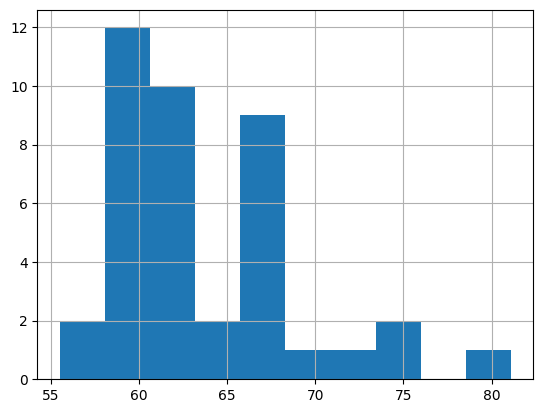

DSO: 63.55244879377146


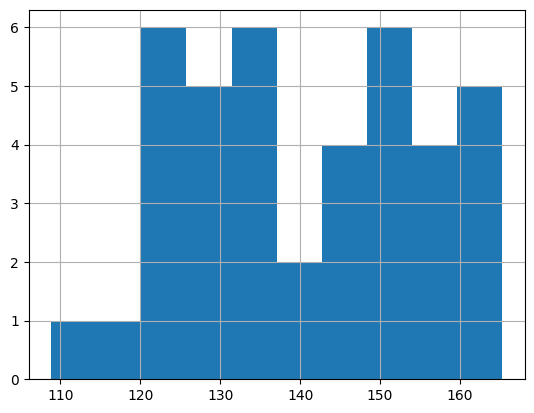

DIO: 140.86621358004723


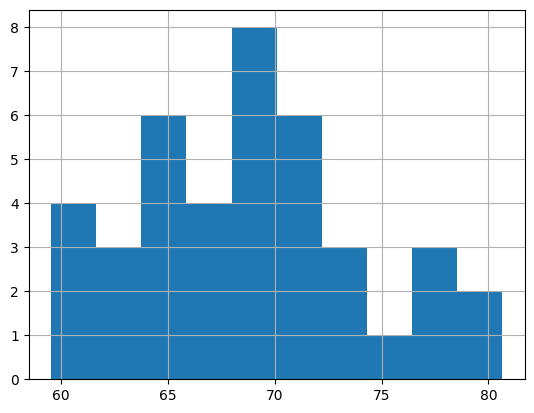

DPO: 69.093054132161


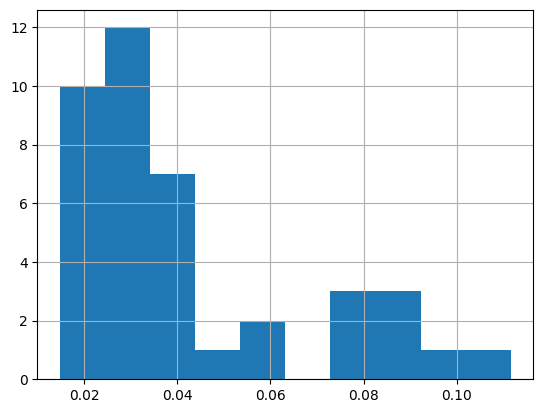

Sum Other Current Assets: 0.04192605674569414


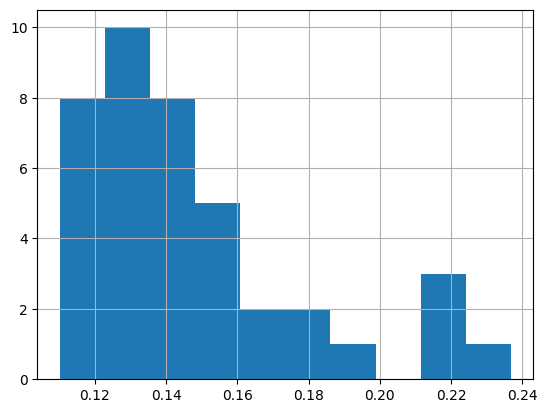

Sum Other Current Liabilities per Rec 0.14663336907971664


In [29]:
nwc_ratios = calculate_nwc_ratios(nwc)

In [30]:
def predict_curr_ass_liab(df_prediction, nwc_ratios):
    # calculate assets, liabilities, and net working capital from NWC ratio
    df_prediction['acc_rec'] = (df_prediction['rev'] * nwc_ratios['dso']) / 360
    df_prediction['invent'] = (df_prediction['cost_sale'] * nwc_ratios['dio']) / 360
    df_prediction['acc_pay'] = (df_prediction['cost_sale'] * nwc_ratios['dpo']) / 360
    
    df_prediction['other_curr_ass_lesscash'] = df_prediction['acc_rec'] + df_prediction['invent'] + (df_prediction['rev'] * nwc_ratios['soca_rev'])
    df_prediction['tot_curr_liab_lessdebt'] = df_prediction['acc_pay'] + (df_prediction['rev'] * nwc_ratios['socl_rev'])
    df_prediction['nwc'] = df_prediction['other_curr_ass_lesscash'] - df_prediction['tot_curr_liab_lessdebt']
    return df_prediction

In [31]:
prediction = predict_curr_ass_liab(prediction, nwc_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc
1,13821.261465,12270.632516,641.990125,0.0,0.0,355.546644,581.960651,9838.414007,908.638824,553.092180,436.942822,2439.930588,4801.437613,2355.042991,7820.839193,4381.701124,3439.138069
2,13589.515884,12064.886835,631.225668,0.0,0.0,363.921669,595.668937,10070.161274,893.403382,529.481713,418.290553,2399.019479,4720.930349,2315.555220,7689.704642,4308.231718,3381.472924
3,14182.205809,12591.081950,658.755795,0.0,0.0,372.493971,609.700126,10307.367430,932.368065,559.874094,442.300534,2503.649746,4926.827886,2416.545296,8025.081598,4496.129915,3528.951682
4,14827.036974,13163.568497,688.707854,0.0,0.0,381.268196,624.061825,10550.161058,974.760623,593.492427,468.859018,2617.484745,5150.839032,2526.419863,8389.962970,4700.558248,3689.404722
5,15173.068943,13470.778598,704.780852,0.0,0.0,390.249101,638.761818,10798.673776,997.509493,607.260392,479.735710,2678.571353,5271.048820,2585.381208,8585.767122,4810.259426,3775.507696


## 2.7. Change in NWC

In [32]:
def calc_change_nwc(df_hist, df_predict):
    c_nwc = []
    # check the 2 DataFrame is equal
    # calculate NWC for measured data
    if df_hist.equals(df_predict):
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(np.nan)
    # calculate NWC for future data
    else:
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_hist['nwc'].iloc[-1])
    
    df_predict['c_nwc'] = c_nwc
    
    return df_predict

In [33]:
prediction = calc_change_nwc(data_filt, prediction)
data_filt = calc_change_nwc(data_filt, data_filt)

In [34]:
def calc_unleveared_fcf(df):
    df['unlev_fcf'] = df['nopat'] + df['depr_amort'] - df['capex'] - df['c_nwc']
    return df

In [35]:
prediction = calc_unleveared_fcf(prediction)
data_filt = calc_unleveared_fcf(data_filt)

## 2.8. Calculate Weighted Average Cost of Capital (WACC)

In [36]:
def calculate_wacc(df, share_price, eff_tax_rate, us_bond_10_yr, equity_risk_premium, beta):
    equity = (share_price * df['shares'].iloc[-1])
    debt = df['short_debt'].iloc[-1] + df['tot_long_debt'].iloc[-1]
    
    cost_of_debt = abs(df['int_exp'].iloc[-1]) / debt
    d_per_d_plus_e = debt / (debt + equity)
    after_tax_cost_of_debt = cost_of_debt * (1 - eff_tax_rate)

    risk_free_rate = us_bond_10_yr
    market_risk_premium = equity_risk_premium
    cost_of_equity = risk_free_rate + (beta * market_risk_premium)
    e_per_d_plus_e = equity / (debt + equity)
    
    wacc = (d_per_d_plus_e * after_tax_cost_of_debt) + (e_per_d_plus_e * cost_of_equity)
    return wacc

In [37]:
wacc = calculate_wacc(
    df=data_filt,
    share_price=share_price,
    eff_tax_rate=eff_tax_rate,
    us_bond_10_yr=us_bond_10_yr,
    equity_risk_premium=equity_risk_premium,
    beta=beta)

print('Estimated WACC value:', wacc)

Estimated WACC value: 0.060621887747925166


## 2.9. Present value of FCF, Terminal Value & present value of TV

In [38]:
def calculate_present_value_fcf(df, report='Q'):
    if report == 'Q':
        multipl = 0.25
    else:
        multipl = 1
    # calculate present cahs flows
    df['pres_val_fcf'] = df['unlev_fcf']/((1+wacc)**(df.index*multipl))
    return df

In [39]:
prediction = calculate_present_value_fcf(prediction, report=report)
prediction.tail()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,c_nwc,unlev_fcf,pres_val_fcf
17,16830.583186,14942.333725,781.771492,0.0,0.0,516.033497,844.646391,14279.283098,1106.477969,590.444472,466.451133,2971.179934,5846.861039,2867.809647,9523.680958,5335.734763,4187.946195,80.251052,57.587187,44.842867
18,16552.723821,14695.647837,768.865075,0.0,0.0,528.188846,864.542331,14615.636583,1088.210909,560.022064,442.417430,2922.128147,5750.334075,2820.464421,9366.452660,5247.646082,4118.806578,-69.139617,175.203562,134.437459
19,16777.965461,14895.619265,779.327427,0.0,0.0,540.630518,884.906927,14959.912992,1103.018769,562.388251,444.286718,2961.891086,5828.581902,2858.843967,9493.906920,5319.053569,4174.853351,56.046773,43.963537,33.241441
20,17165.129605,15239.346857,797.310993,0.0,0.0,553.365258,905.751218,15312.298951,1128.471755,575.106497,454.334132,3030.238945,5963.080803,2924.813937,9712.985946,5441.794722,4271.191225,96.337874,5.610299,4.180065
21,17185.794338,15257.693182,798.270858,0.0,0.0,566.399970,927.086503,15672.985485,1129.830298,563.430328,445.109959,3033.886985,5970.259629,2928.335058,9724.679203,5448.345982,4276.333221,5.141996,79.281430,58.207427


## 2.10. Terminal Value and present value of TV

I use the perpetuity growth model

In [40]:
def calculate_tv_prestv_enterp_val(df, industry_growth_rate, wacc):
    # Terminal Value
    tv = ((df['unlev_fcf'].iloc[-1] * (1 + industry_growth_rate))) / (wacc - industry_growth_rate)
    # present value of TV
    pres_value_tv = tv / (1 + wacc)**5
    
    return tv, pres_value_tv

In [41]:
tv, pres_value_tv = calculate_tv_prestv_enterp_val(prediction, industry_growth_rate, wacc)
pres_value_tv

2070.3364034693013

In [42]:
def calc_enterp_company_value(df_hist, df_pred, pres_value_tv):
    
    debt = df_hist['short_debt'].iloc[-1] + df_hist['tot_long_debt'].iloc[-1]
    
    if 'equity_minor_interest' in df_hist.columns:
        equity_minor_interest = df_hist['equity_minor_interest'].iloc[-1]
    else:
        equity_minor_interest = 0
    # Enterprise Values
    enterp_val = df_pred['pres_val_fcf'].sum() + pres_value_tv
    # Company Value
    comp_val = enterp_val + df_hist['cash_cash_eq'].iloc[-1] + df_hist['short_inv'].iloc[-1] - debt - equity_minor_interest
    

    print(enterp_val, comp_val)
    return enterp_val, comp_val

In [43]:
enterp_val, equity_value = calc_enterp_company_value(data_filt, prediction, pres_value_tv)

4547.1807663034015 -4073.8192336965985


In [44]:
def implied_share_price(equity_value, hist_df):
    share_price = equity_value / hist_df['shares'].iloc[-1]
    return share_price

In [45]:
# adjusted with debt, cash, equity in minor interest
fcst_share_price_adjusted = implied_share_price(equity_value, data_filt)
print('Current adjusted share price:', fcst_share_price_adjusted)

Current adjusted share price: -11.507963936996042


In [46]:
fcst_share_price = implied_share_price(enterp_val, data_filt)
print('Current share price (not adjusted):', fcst_share_price)

Current share price (not adjusted): 12.845143407636728


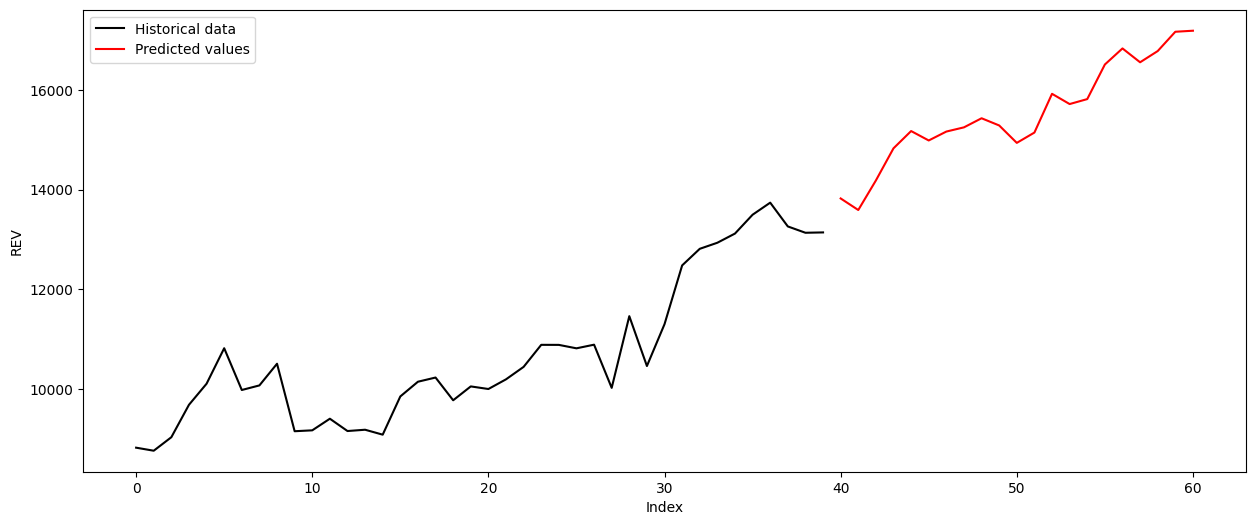

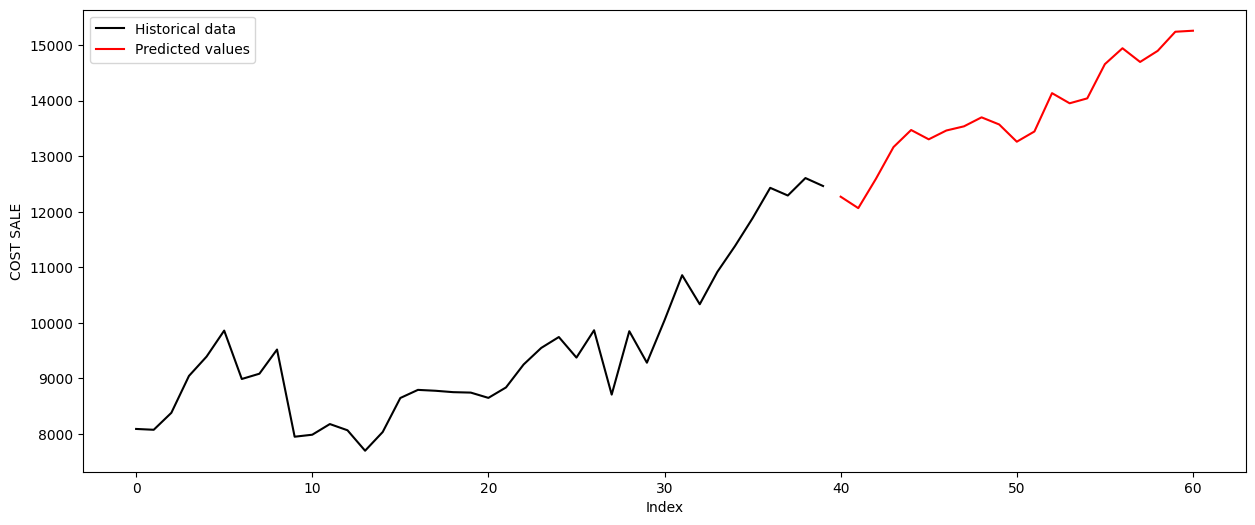

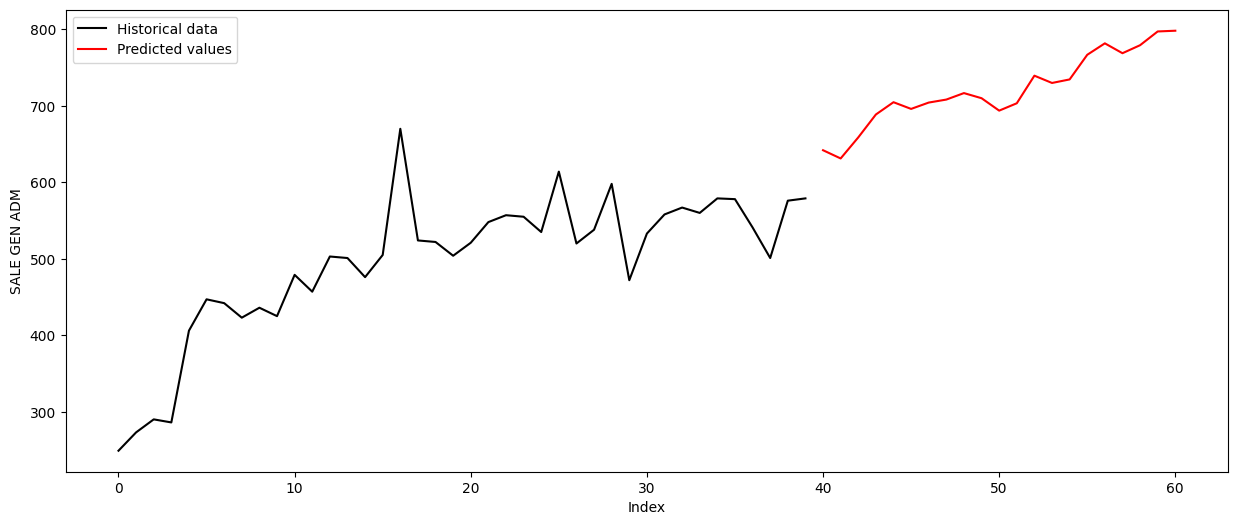

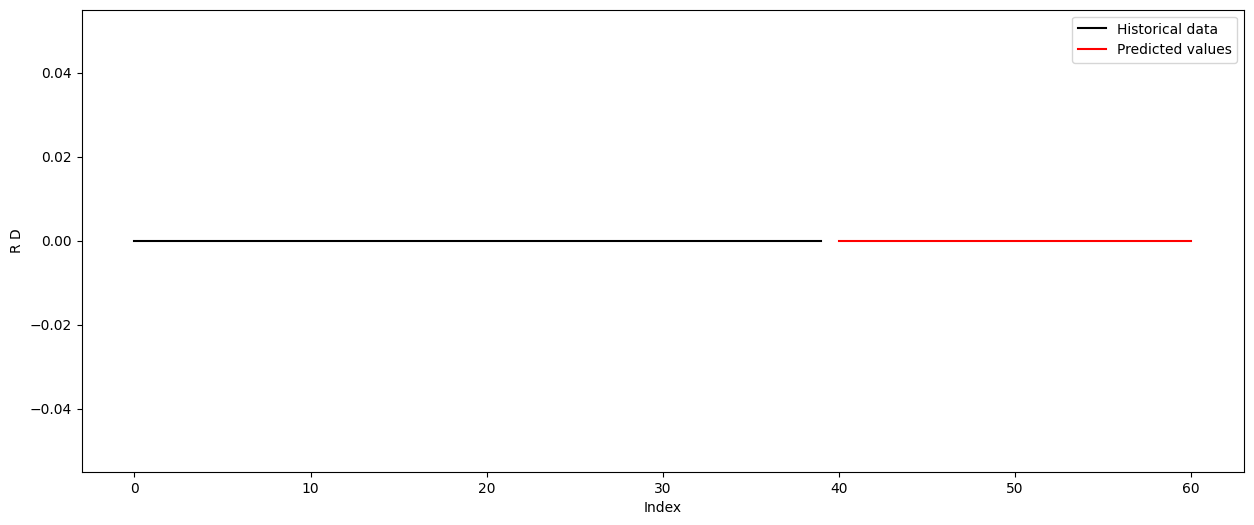

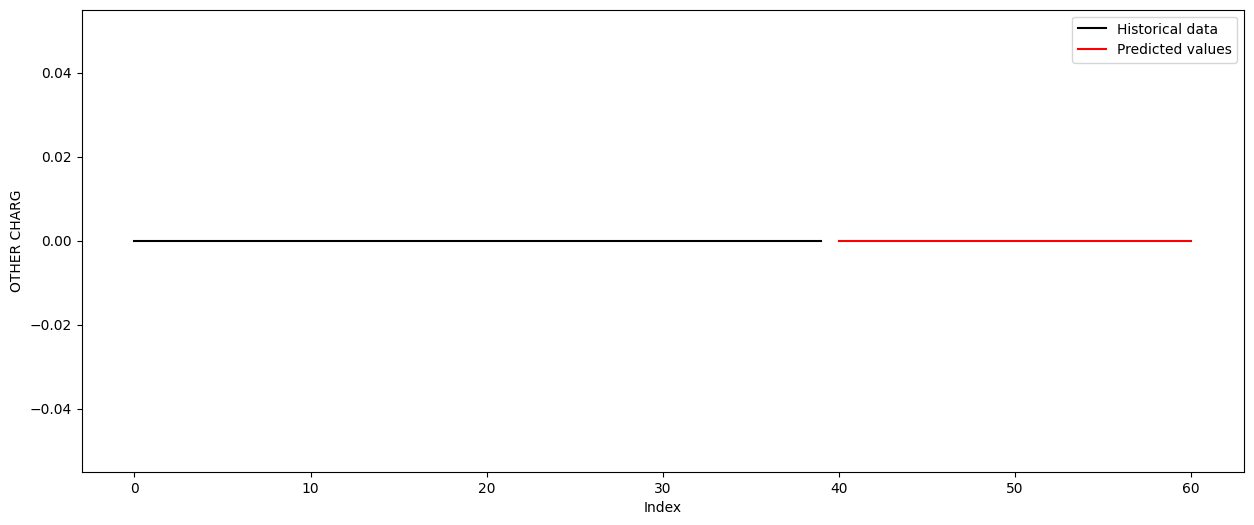

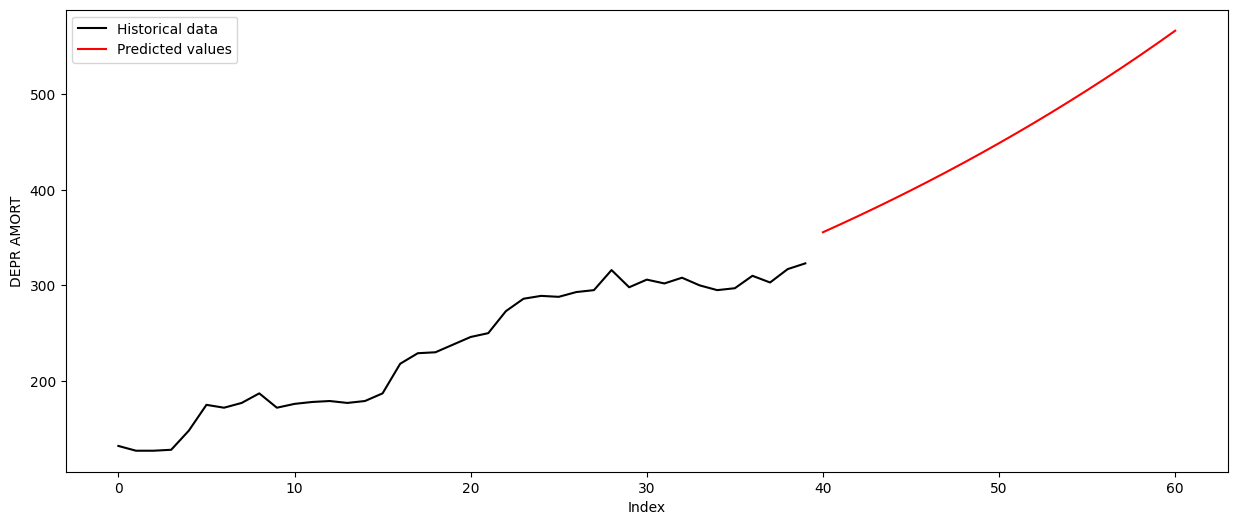

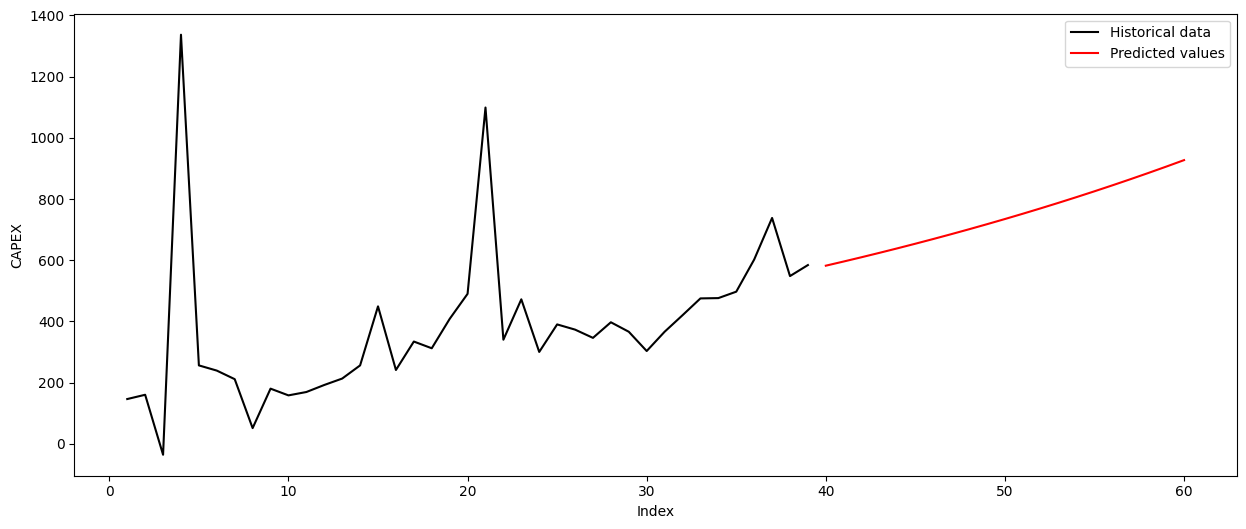

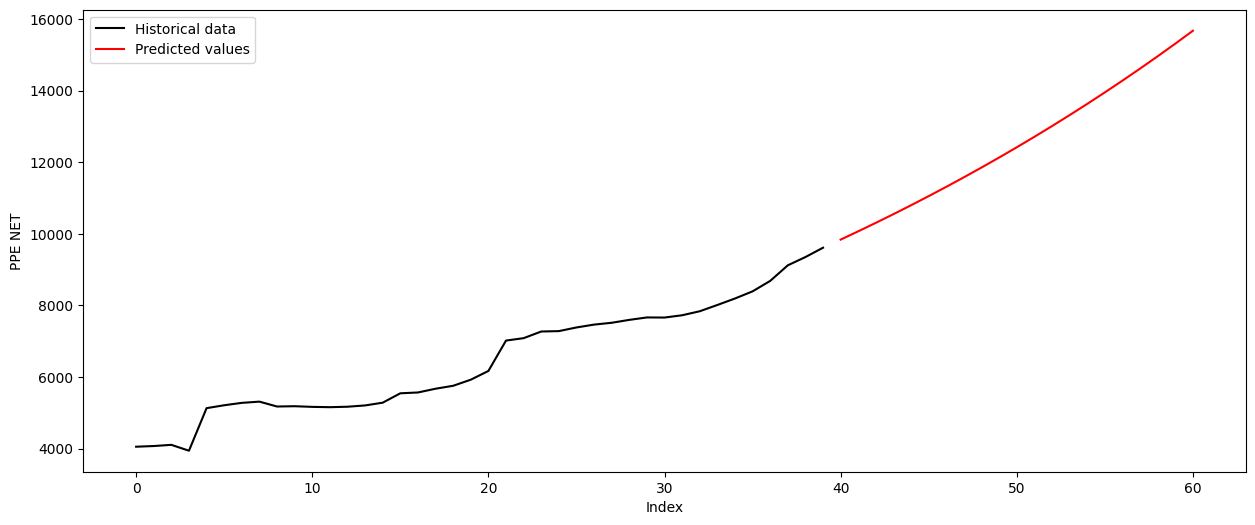

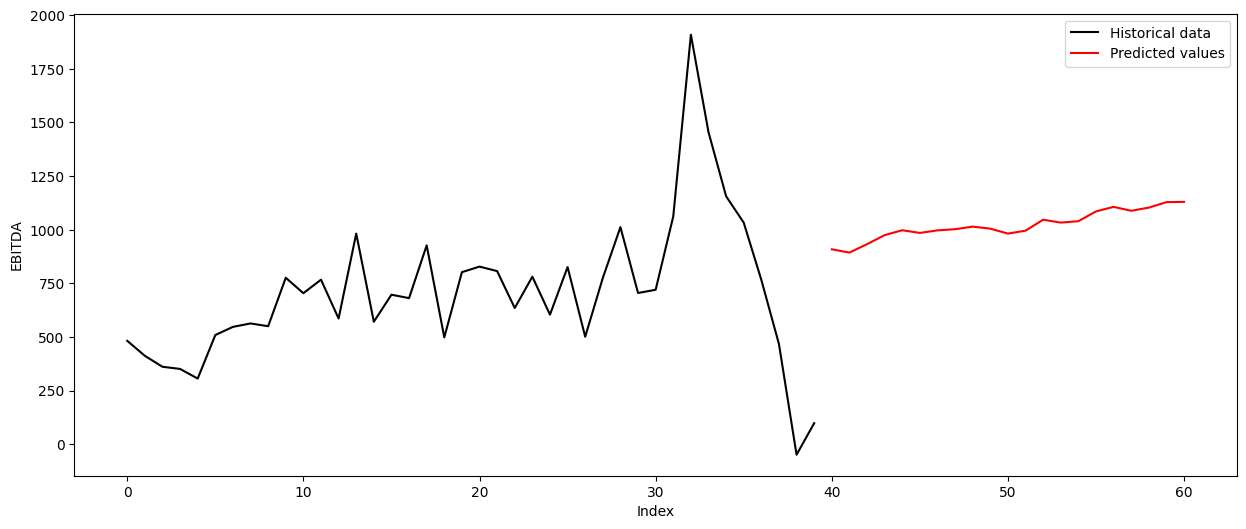

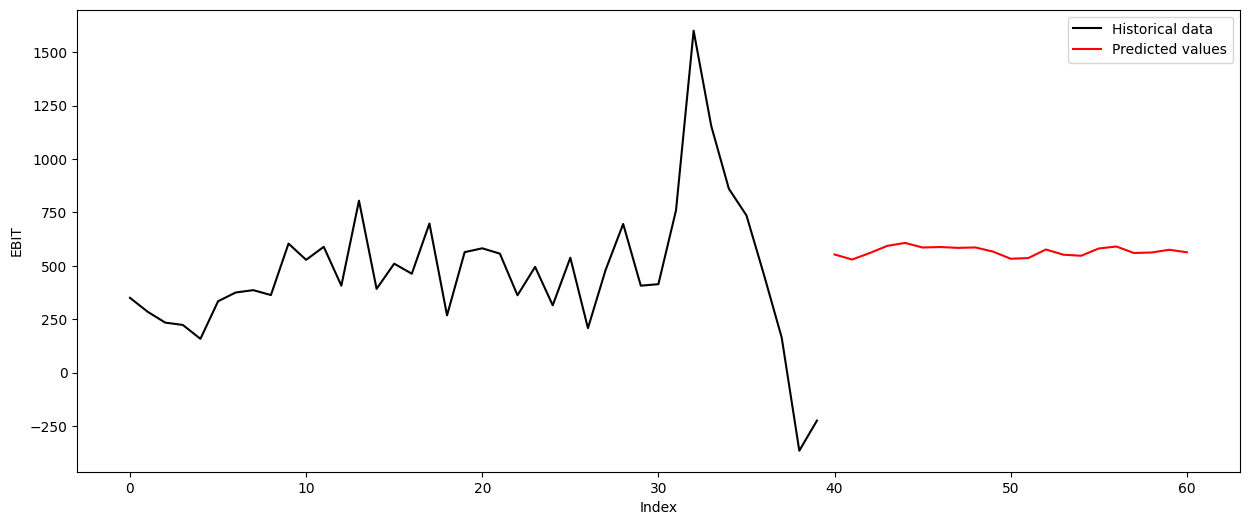

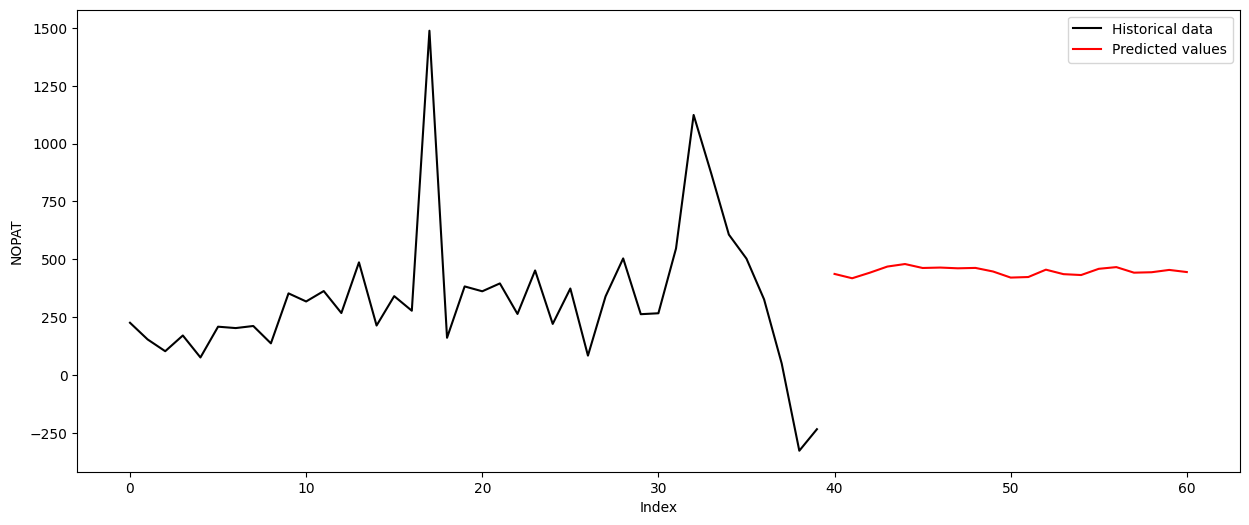

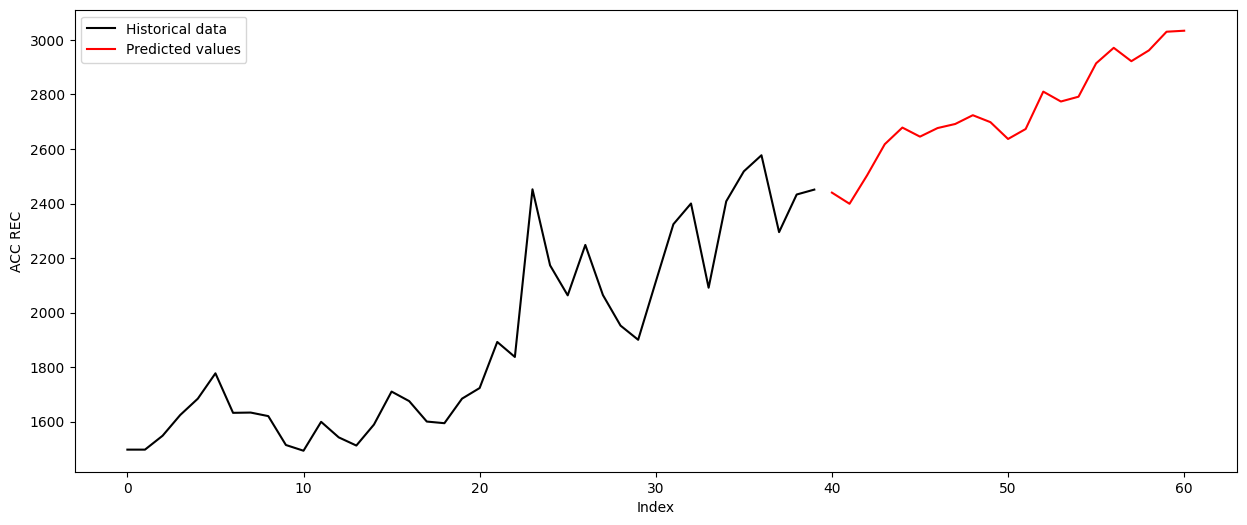

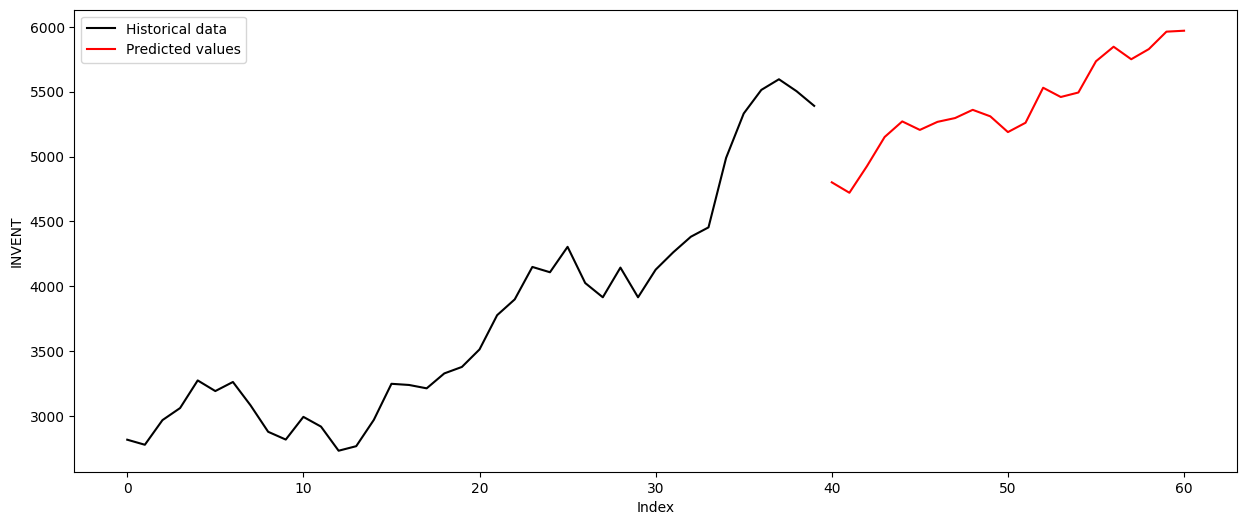

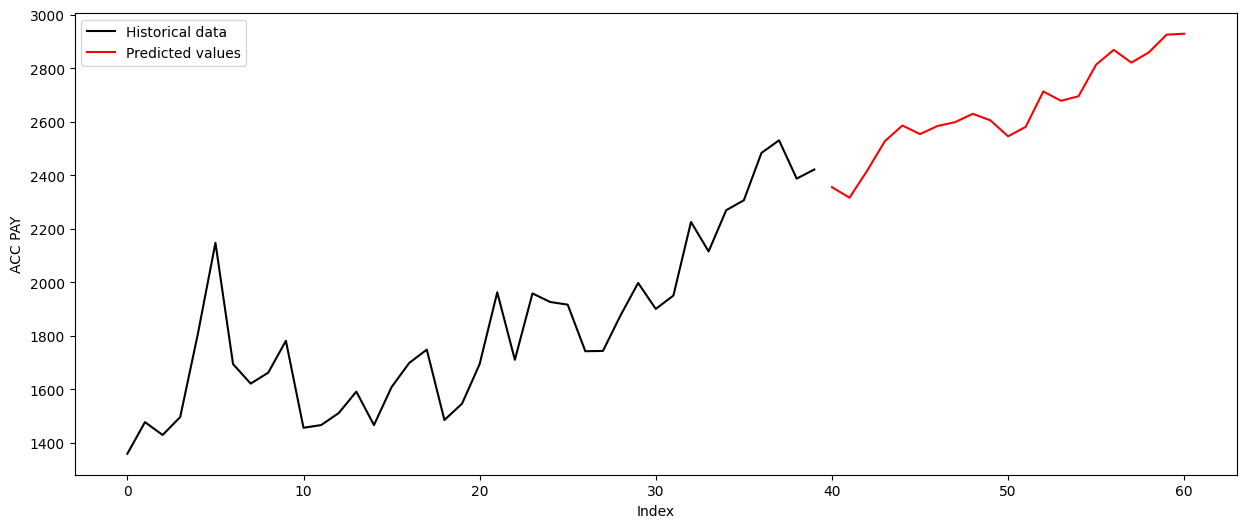

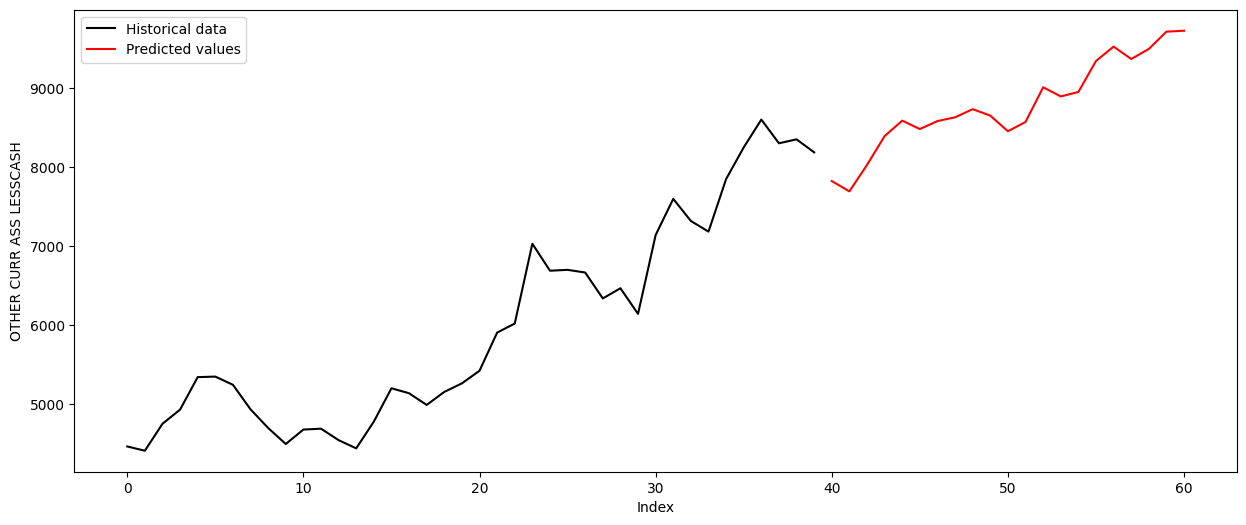

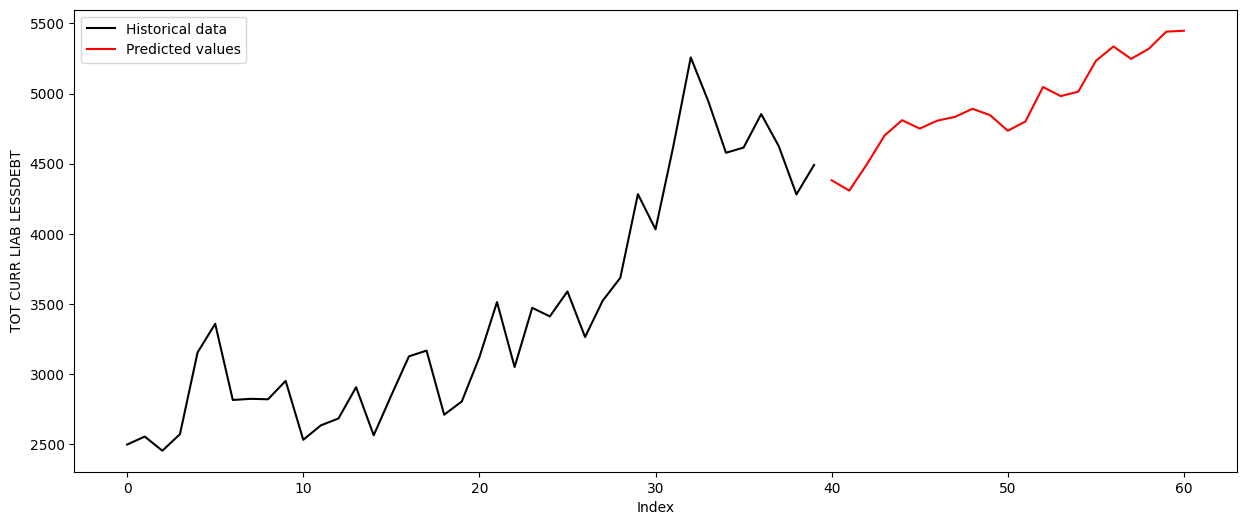

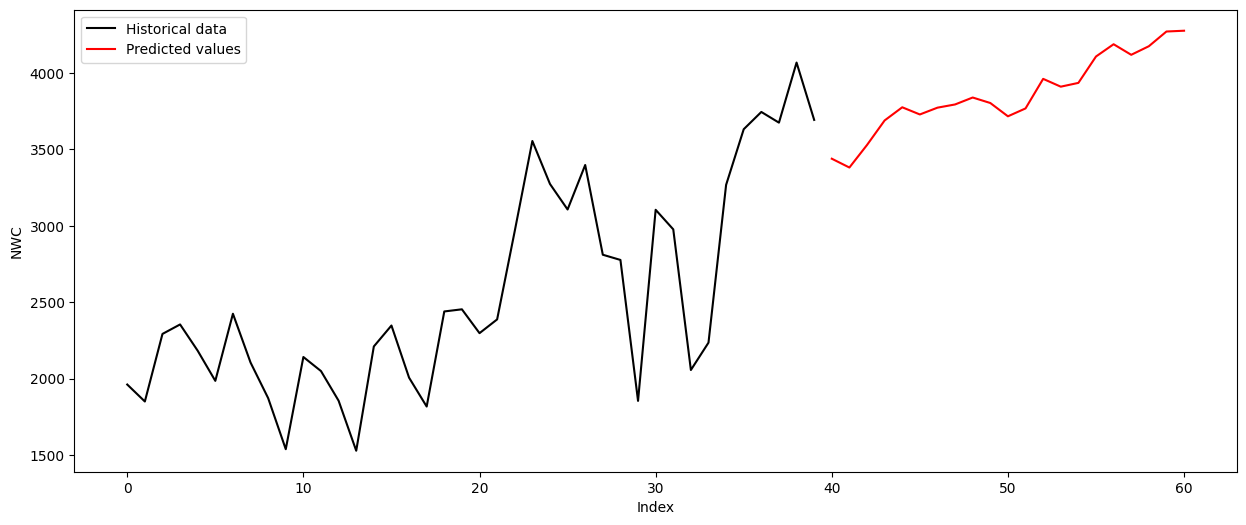

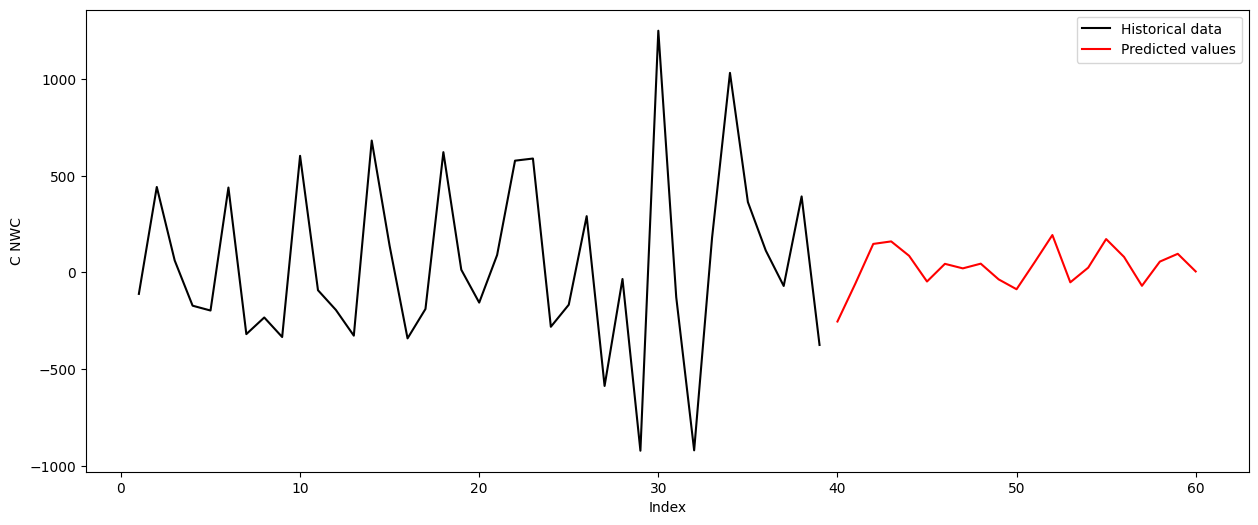

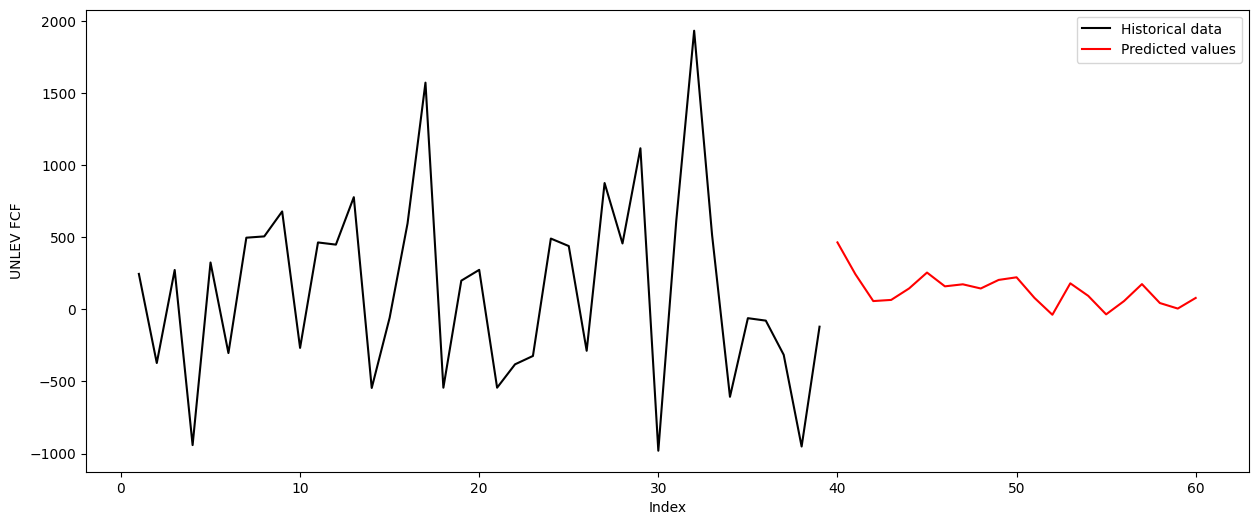

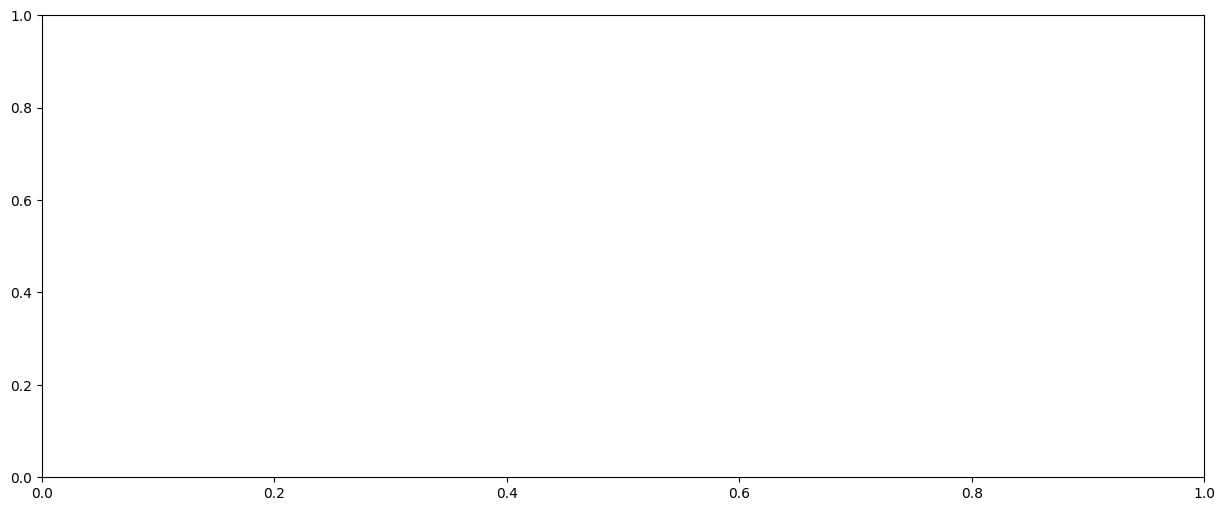

In [47]:
plot_hist_pred(data_filt, prediction)